In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from scipy.fft import fft, fftfreq 
import pickle
from sklearn.model_selection import StratifiedKFold
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import datetime

In [3]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [4]:
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.8.0



In [2]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [3]:
SAMPLE_RATE = 119
LABEL_MAP = {"RIGHT": 1, "LEFT": -1}
WINDOW_SIZE = 150 #this should be variable
WINDOW_STEP = 1 #this should be variable
SIGNALS = "aX,aY,aZ,gX,gY,gZ,mX,mY,mZ"
SIGNALS = SIGNALS.split(",")
FEATURES = "max,min,mean,var,median"#,amplitude,freq"
FEATURES = FEATURES.split(",")
MOVE_SIZE = 150
FEATURES_PER_WINDOW = 45
CLASSES = 3

In [4]:
data_df = pd.read_csv("still_first.csv")

FileNotFoundError: ignored

In [5]:
clean_data(data_df)
data_df

NameError: ignored

In [6]:
label_df = pd.read_csv("still_home_1.csv")

FileNotFoundError: ignored

In [ ]:
label_df["time"] = label_df["time"].str.replace(" ", "")
label_df

,time,move
0,22:6:22:208,LEFT
1,22:6:28:846,LEFT
2,22:6:36:977,LEFT
3,22:6:45:429,RIGHT
4,22:6:54:451,LEFT
5,22:7:18:213,LEFT
6,22:7:23:283,RIGHT
7,22:7:34:758,LEFT
8,22:7:40:203,LEFT
9,22:7:51:639,RIGHT


In [4]:
def clean_data(data_df):
    data_df.rename(columns={data_df.columns[0] : "time"}, inplace=True)
    data_df["time"] = data_df["time"].str.strip("\t")
    data_df.drop(data_df.tail(1).index,inplace=True) # drop last n rows

In [5]:
def get_sig_stats(sig):
    maxi, mini = np.max(sig), np.min(sig)
    avg, var = np.mean(sig), np.var(sig)
    median = np.median(sig)
    
    #_sig = copy.deepcopy(sig)
    #_sig = _sig - np.mean(sig)
    
    #fourierTransform = np.fft.rfft(_sig)/len(_sig)           # Normalize amplitude
    #fourierTransform = fourierTransform[range(int(len(_sig)/2))] # Exclude sampling frequency
    
    #amplitude, freq = np.abs(np.max(fourierTransform)), np.argmax(fourierTransform)
    
    return maxi, mini, avg, var, median#, amplitude, freq

In [6]:
def normalize_columns(values, column_type="g"):
    if column_type == "g":
        mini, maxi, start_col, stop_col = -2000, 2000, 3, 6
    elif column_type == "a":
        mini, maxi, start_col, stop_col = -4, 4, 0, 3
    elif column_type == "m":
        mini, maxi, start_col, stop_col = -400, 400, 6, 9
    
    values[:, start_col:stop_col] = (values[:, start_col:stop_col] - mini)/(maxi-mini) 

In [7]:
def generate_columns(features, sigs):
    cols = []
    for sig in sigs:
        for ft in features:
            cols.append(sig + "_" + ft)
            
    return cols

In [8]:
def fill_windows_list(windows_list, signals):
    for sig in range(len(signals)):
        signal = signals[sig]
        #print(signal.shape)
        #break
        i = 0
        while i < (len(windows_list)):
            sig_to_eval = signal[i:i+WINDOW_SIZE]
            #print(sig_to_eval.shape)
            windows_list[i, sig*len(FEATURES):sig*len(FEATURES)+len(FEATURES)] = np.array(get_sig_stats(sig_to_eval))
            i += WINDOW_STEP

In [9]:
def time_to_float(time_list):
    float_list = []
    for t in time_list:
        ti = t.split(":")
        my_float = 0
        if len(ti) == 3:
            my_float += int(ti[0]) * 3600 + int(ti[1]) * 60 + float(ti[2])
        elif len(ti) == 4:
            my_float += int(ti[0]) * 3600 + int(ti[1]) * 60 + int(ti[2]) + float("0." + ti[3])
            
        float_list.append(my_float)
        
    return float_list

In [10]:
def find_starting_point(elem, search_list):
    for i in range(len(search_list) - 1):
        if elem >= search_list[i] and elem <= search_list[i+1]:
            return i+1

In [11]:
def convert_df_time(label, data):
    label_time_list = label["time"].to_list()
    data_time_list = data["time"].to_list()
    
    label_float_list = time_to_float(label_time_list)
    data_float_list = time_to_float(data_time_list)
    
    label["time"] = label_float_list
    data["time"] = data_float_list

In [12]:
def create_label_entries(label, data, threshold=0.8, normalize=True):    
    signals = data.values
    signals = copy.deepcopy(signals[:, 1:])
    
    if normalize:
        normalize_columns(signals, "a")
        normalize_columns(signals, "g")
        normalize_columns(signals, "m")
    
    signals = np.transpose(signals)
    
    labels_no_window_list = np.zeros((len(data), ))    
    labels_window_list = np.zeros((len(data) - WINDOW_SIZE, ))  
    
    windows_list = np.zeros((len(data) - WINDOW_SIZE, len(SIGNALS)*len(FEATURES)))
    
    fill_windows_list(windows_list, signals)
    
    label_float_list = label["time"].to_list()
    data_float_list = data["time"].to_list()
    
    for i_label in range(len(label)):
        label_start_point = find_starting_point(label_float_list[i_label], data_float_list)
        labels_no_window_list[label_start_point:label_start_point+MOVE_SIZE] = LABEL_MAP[label.iloc[i_label, label.columns.get_loc("move")]]

    for i_window in range(len(labels_window_list)):
        label_sum = np.sum(labels_no_window_list[i_window : i_window + WINDOW_SIZE])
        proportion = abs(label_sum)/WINDOW_SIZE
        
        if proportion > threshold:
            if label_sum < 0:
                #there is left
                labels_window_list[i_window] = -1
            elif label_sum > 0:
                #there is right
                labels_window_list[i_window] = 1
            #0 is by default cause it's set to 0
    
    return windows_list, labels_window_list

In [13]:
def create_window_data_df(windows, windows_labels):
    cols = generate_columns(sigs=SIGNALS, features=FEATURES) + ["label"]
    windows_labels.reshape(windows_labels.shape[0],-1)
    
    columned_labels = np.array([windows_labels])
    columned_labels = columned_labels.T
    
    all_values = np.append(windows, columned_labels, axis=1)
    
    df = pd.DataFrame(all_values, index=[i for i in range(len(all_values))], columns=cols)
    
    return df

In [14]:
def define_model(lr=0.005):
    model = tf.keras.Sequential([ #input shape = (batch, 300, 6, 1)
    #keras.Input(shape=(FEATURES_PER_WINDOW, 1)),
    tf.keras.layers.Dense(64, activation="relu", name="Dense1"),#, input_shape=(FEATURES_PER_WINDOW, 1)),
    tf.keras.layers.Dense(128, activation="relu", name="Dense1_1"),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation="relu", name="Dense1_2"),
    tf.keras.layers.Dropout(0.4),     
    tf.keras.layers.Dense(32, activation="relu", name="Dense2"),
    tf.keras.layers.Dense(16, activation="relu", name="Dense3"),
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Flatten(name="Flatten"),
    tf.keras.layers.Dense(8, activation="relu", name="Dense4"),
    tf.keras.layers.Dense(3, activation="softmax", name="Output")
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalCrossentropy()])

    return model

In [55]:
def define_model_2(lr=0.005, classes=3):
    model = tf.keras.Sequential([ #input shape = (batch, 300, 6, 1)
    #keras.Input(shape=(FEATURES_PER_WINDOW, 1)),
    tf.keras.layers.Dense(64, activation="relu", name="Dense1"),#, input_shape=(FEATURES_PER_WINDOW, 1)),
    #tf.keras.layers.Dense(128, activation="relu", name="Dense1_1"),
    #tf.keras.layers.Dropout(0.5), 
    #tf.keras.layers.Dense(64, activation="relu", name="Dense1_2"),
    tf.keras.layers.Dropout(0.4),     
    tf.keras.layers.Dense(32, activation="relu", name="Dense2"),
    tf.keras.layers.Dense(16, activation="relu", name="Dense3"),
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Flatten(name="Flatten"),
    tf.keras.layers.Dense(8, activation="relu", name="Dense4"),
    tf.keras.layers.Dense(classes, activation="softmax", name="Output")
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalCrossentropy()])

    return model

In [54]:
def define_model_3(lr=0.005, classes=3):
    model = tf.keras.Sequential([ #input shape = (batch, 300, 6, 1)
    #keras.Input(shape=(FEATURES_PER_WINDOW, 1)),
    #tf.keras.layers.Dense(64, activation="relu", name="Dense1"),#, input_shape=(FEATURES_PER_WINDOW, 1)),
    #tf.keras.layers.Dense(128, activation="relu", name="Dense1_1"),
    #tf.keras.layers.Dropout(0.5), 
    #tf.keras.layers.Dense(64, activation="relu", name="Dense1_2"),
    #tf.keras.layers.Dropout(0.4),     
    #tf.keras.layers.Dense(32, activation="relu", name="Dense2"),
    tf.keras.layers.Dense(16, activation="relu", name="Dense3"),
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Flatten(name="Flatten"),
    tf.keras.layers.Dense(8, activation="relu", name="Dense4"),
    tf.keras.layers.Dense(classes, activation="softmax", name="Output")
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalCrossentropy()])

    return model

In [17]:

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, new_Y, n_folds=5):
    scores, histories, categ_crossentropies = list(), list(), list()
    # prepare cross validation
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX, new_Y):
        # define model
        model = define_model_3(lr=0.02)
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        #print(trainY.shape)
        #print(trainX.shape)
        
        history = model.fit(trainX, trainY, epochs=35, batch_size=32, verbose=1, callbacks=[tensorboard_callback])#, validation_data=(testX, testY), verbose=1, callbacks=[tensorboard_callback])
        # evaluate model
        categ_crossentropy, acc, _ = model.evaluate(testX, testY, verbose=0)

        print('> %.3f' % (acc * 100.0))
        print(f'> {categ_crossentropy}')
        # stores scores
        scores.append(acc)
        histories.append(history)
        categ_crossentropies.append(categ_crossentropy)
    return scores, histories, categ_crossentropies

In [18]:
def one_hot_encode(to_encode):
    one_hot_list = np.zeros((len(to_encode), CLASSES),dtype=int)
    for i in range(len(to_encode)):
        #print(to_encode[i])
        one_hot_list[i, to_encode[i][0]] = 1
        
    return one_hot_list

In [19]:
def prep_data(main_data):
    data = main_data.values
    dataX = copy.deepcopy(data[:, :-1]) #all Xs
    dataY = copy.deepcopy(data[:, -1:]) #all Ys
    dataY += 1 #0 left, 1 nothing, 2 right
    #print(dataY)
    
    one_hot_Y = one_hot_encode(dataY.astype(int))
    
    return dataX, dataY.T[0].astype(int), one_hot_Y

In [20]:
def get_X_Y_bal(idxs, X, Y, one_hot_Y):
    bal_X = X[idxs]
    bal_Y = Y[idxs]
    bal_one_hot_Y = one_hot_Y[idxs]
    
    return bal_X, bal_Y, bal_one_hot_Y

In [21]:
def get_no_magnetometer_data(dataX):
    return dataX[:, :30]

In [22]:
def get_balanced_dataset(dataX, dataY, one_hot_Y, seed = 0):
    np.random.seed(seed)
    no_idx, left_idx, right_idx = np.where(dataY == 1), np.where(dataY == 0), np.where(dataY == 2)
    bal_size = min(len(left_idx[0]), len(right_idx[0]))
    bal_left, bal_nothing, bal_right = np.random.choice(left_idx[0], size=bal_size, replace=False), np.random.choice(no_idx[0], size=bal_size, replace=False), np.random.choice(right_idx[0], size=bal_size, replace=False)   
    all_balanced_idxs = np.concatenate([bal_nothing, bal_left, bal_right])
    bal_X, bal_Y, bal_one_hot_Y = get_X_Y_bal(all_balanced_idxs, dataX, dataY, one_hot_Y)
    
    return bal_X, bal_Y, bal_one_hot_Y

In [23]:
def pickle_object(obj, filename):
    with open(filename + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

In [24]:
def train_model(model, train_data_X, train_data_Y, callbacks=[], epochs=10, batch_size=64, verbose=1, validation_split=0.0):
    #model = define_model()
    model.fit(train_data_X, train_data_Y, callbacks=callbacks, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=validation_split)

In [25]:
def save_model_lite(model, model_name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model to disk
    open(model_name + ".tflite", "wb").write(tflite_model)

    basic_model_size = os.path.getsize(model_name + ".tflite")
    print("Model is %d bytes" % basic_model_size)

In [26]:

# evaluate a model using k-fold cross-validation
def evaluate_tflite_model(dataX, dataY, new_Y, n_folds=5, lr=0.005, bs=64):
    scores, histories, categ_crossentropies = list(), list(), list()
    
    # prepare cross validation
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX, new_Y):
        # define model
        s = 0
        model = define_model_2(lr=lr)
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        #print(trainY.shape)
        #print(trainX.shape)
        
        history = model.fit(trainX, trainY, epochs=50, batch_size=bs, verbose=1, callbacks=[tensorboard_callback])#, validation_data=(testX, testY), verbose=1, callbacks=[tensorboard_callback])
        # evaluate model
        save_model_lite(model, "tflite_test")
        preds = predict_tflite("tflite_test.tflite", testX)
        #categ_crossentropy, acc, _ = model.evaluate(testX, testY, verbose=0)
        for i in range(len(preds)):
          if preds[i] == np.argmax(testY[i]):
            s += 1
        acc = s/len(preds) 
        print('> %.3f' % (acc * 100.0))
        #print(f'> {categ_crossentropy}')
        # stores scores
        scores.append(acc)
        #histories.append(history)
        #categ_crossentropies.append(categ_crossentropy)
    return scores

In [27]:
def predict_tflite(filename, testing_X):
  interpreter = tf.lite.Interpreter(model_path=filename)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  preds = []
  # Test model on random input data.
  input_shape = input_details[0]['shape']
  for idx in range(len(testing_X)):
    inp = testing_X[idx].reshape((1,30))
    inp = inp.astype(np.float32)
    #input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], inp)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    preds.append(np.argmax(output_data[0]))
    #ok = np.argmax(output_data[0]) == np.argmax(testing_Y[idx])
    #s+=ok
    #print(output_data[0])
  return preds
  #print(s)

In [28]:
def get_prepared_data(data_filename, label_filename, threshold=0.8):
  data_df = pd.read_csv(data_filename)
  label_df = pd.read_csv(label_filename)

  clean_data(data_df)
  label_df["time"] = label_df["time"].str.replace(" ", "")

  convert_df_time(label_df, data_df)
  windows_list, windows_labels = create_label_entries(label_df, data_df, threshold=threshold)
  main_df = create_window_data_df(windows_list, windows_labels)

  return main_df

In [29]:
convert_df_time(label_df, data_df)

NameError: ignored

In [ ]:
###TESTING FUNCTION LABEL
windows_list, windows_labels = create_label_entries(label_df, data_df)

In [ ]:
main_df = create_window_data_df(windows_list, windows_labels)

In [ ]:
main_df

,aX_max,aX_min,aX_mean,aX_var,aX_median,aY_max,aY_min,aY_mean,aY_var,aY_median,...,mY_min,mY_mean,mY_var,mY_median,mZ_max,mZ_min,mZ_mean,mZ_var,mZ_median,label
0,0.440500,0.431500,0.432673,7.082889e-07,0.432625,0.507875,0.505750,0.507108,1.001389e-07,0.507125,...,0.556946,0.557925,1.332732e-07,0.558029,0.496170,0.494201,0.495338,2.618701e-07,0.495391,0.0
1,0.437750,0.431500,0.432613,3.054889e-07,0.432625,0.507875,0.506250,0.507123,9.155625e-08,0.507125,...,0.556946,0.557927,1.326578e-07,0.558029,0.496170,0.494201,0.495332,2.643901e-07,0.495391,0.0
2,0.437750,0.431500,0.432602,2.963306e-07,0.432625,0.507875,0.506250,0.507127,8.895556e-08,0.507125,...,0.556946,0.557928,1.320384e-07,0.558029,0.496170,0.494201,0.495326,2.668381e-07,0.495391,0.0
3,0.433375,0.431500,0.432567,1.184722e-07,0.432625,0.507875,0.506375,0.507132,8.391389e-08,0.507125,...,0.556946,0.557932,1.318000e-07,0.558029,0.496170,0.494201,0.495324,2.664538e-07,0.495384,0.0
4,0.433375,0.431500,0.432565,1.178583e-07,0.432625,0.507875,0.506375,0.507128,8.478056e-08,0.507125,...,0.556946,0.557936,1.315302e-07,0.558029,0.496170,0.494201,0.495322,2.660604e-07,0.495376,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62250,0.441875,0.440625,0.441152,6.288958e-08,0.441125,0.514750,0.513375,0.514288,3.936389e-08,0.514312,...,0.559127,0.559946,1.258307e-07,0.560028,0.487809,0.485459,0.486516,5.003555e-07,0.486420,0.0
62251,0.441875,0.440625,0.441158,6.383958e-08,0.441125,0.514750,0.513375,0.514290,3.923333e-08,0.514375,...,0.559127,0.559938,1.253841e-07,0.560005,0.487809,0.485459,0.486527,5.098931e-07,0.486466,0.0
62252,0.441875,0.440625,0.441162,6.407222e-08,0.441125,0.514750,0.513375,0.514295,3.755833e-08,0.514375,...,0.559127,0.559930,1.264583e-07,0.559982,0.487809,0.485459,0.486536,5.199156e-07,0.486511,0.0
62253,0.441875,0.440625,0.441164,6.419514e-08,0.441125,0.514750,0.513375,0.514298,3.724722e-08,0.514375,...,0.559127,0.559923,1.274251e-07,0.559982,0.487809,0.485459,0.486545,5.297779e-07,0.486511,0.0


In [31]:
df1 = get_prepared_data(data_filename = "data_1.csv", label_filename = "label_1.csv",threshold=0.9)
#df2 = get_prepared_data(data_filename = "data_2.csv", label_filename = "label_2.csv")
#df3 = get_prepared_data(data_filename = "data_3.csv", label_filename = "label_3.csv", threshold=0.9)
df4 = get_prepared_data(data_filename = "data_4.csv", label_filename = "label_4.csv", threshold=0.9)

In [32]:
main_df = pd.concat([df1, df4], axis=0)

In [33]:
dX, dY, one_hot_Y = prep_data(main_df)

In [34]:
print(np.sum(one_hot_Y, axis=0)) #number of entries per gesture type L N R

[ 1769 98445  1653]


In [38]:
null_idx = np.where(dY == 1)[0]
print(len(null_idx))

98445


In [42]:
test_dataX = dX[~np.in1d(np.arange(dX.shape[0]),null_idx)]
test_dataX.shape

(3422, 45)

In [49]:
test_one_hot_Y = one_hot_Y[~np.in1d(np.arange(dX.shape[0]),null_idx)]
print(test_one_hot_Y.shape)
test_one_hot_Y = np.delete(test_one_hot_Y, 1, axis=1)

(3422, 3)


In [50]:
print(np.sum(test_one_hot_Y, axis=0))

[1769 1653]


In [51]:
test_no_mX = get_no_magnetometer_data(test_dataX)

In [57]:
model = define_model_2(lr=0.002, classes=2)
train_model(model, test_no_mX, test_one_hot_Y, epochs=100, batch_size=32)

Epoch 1/100
107/107 [==============================] - 1s 4ms/step - loss: 0.4887 - accuracy: 0.7472 - categorical_crossentropy: 0.4887
Epoch 2/100
107/107 [==============================] - 0s 4ms/step - loss: 0.1237 - accuracy: 0.9711 - categorical_crossentropy: 0.1237
Epoch 3/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0923 - accuracy: 0.9790 - categorical_crossentropy: 0.0923
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0859 - accuracy: 0.9795 - categorical_crossentropy: 0.0859
Epoch 5/100
107/107 [==============================] - 0s 5ms/step - loss: 0.0891 - accuracy: 0.9784 - categorical_crossentropy: 0.0891
Epoch 6/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0876 - accuracy: 0.9807 - categorical_crossentropy: 0.0876
Epoch 7/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0762 - accuracy: 0.9819 - categorical_crossentropy: 0.0762
Epoch 8/100
107/107 [===========================

In [58]:
save_model_lite(model, "no_magneto_2_classes")

INFO:tensorflow:Assets written to: /tmp/tmpqry6qdmh/assets


INFO:tensorflow:Assets written to: /tmp/tmpqry6qdmh/assets


Model is 21808 bytes


In [59]:
! apt-get -qq install xxd


!echo "const unsigned char model_data[] = {" > /content/model_small.h
!cat no_magneto_2_classes.tflite | xxd -i      >> /content/model_small.h
!echo "};"                              >> /content/model_small.h

import os
model_h_size = os.path.getsize("model_small.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Selecting previously unselected package xxd.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Header file, model.h, is 134,523 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [ ]:
########## end of test with 2 outcomes

In [34]:
dataX = dX.reshape((dX.shape[0], len(FEATURES)*len(SIGNALS)))

In [35]:
dataX.shape

(101867, 45)

In [36]:
no_mX = get_no_magnetometer_data(dataX)

In [38]:
model = define_model_2(lr=0.005)
train_model(model, no_mX, one_hot_Y, epochs=100, batch_size=256)

Epoch 1/100
398/398 [==============================] - 3s 5ms/step - loss: 0.2544 - accuracy: 0.9076 - categorical_crossentropy: 0.2544
Epoch 2/100
398/398 [==============================] - 1s 4ms/step - loss: 0.1934 - accuracy: 0.9130 - categorical_crossentropy: 0.1934
Epoch 3/100
398/398 [==============================] - 1s 3ms/step - loss: 0.1782 - accuracy: 0.9127 - categorical_crossentropy: 0.1782
Epoch 4/100
398/398 [==============================] - 1s 3ms/step - loss: 0.1718 - accuracy: 0.9125 - categorical_crossentropy: 0.1718
Epoch 5/100
398/398 [==============================] - 1s 3ms/step - loss: 0.1718 - accuracy: 0.9124 - categorical_crossentropy: 0.1718
Epoch 6/100
398/398 [==============================] - 1s 3ms/step - loss: 0.1722 - accuracy: 0.9125 - categorical_crossentropy: 0.1722
Epoch 7/100
398/398 [==============================] - 1s 3ms/step - loss: 0.1706 - accuracy: 0.9126 - categorical_crossentropy: 0.1706
Epoch 8/100
398/398 [===========================

In [37]:
bal_X, bal_Y, bal_one_hot_Y = get_balanced_dataset(dX, dY, one_hot_Y)

In [70]:
nom_bal_X, nom_bal_Y, nom_bal_one_hot_Y = get_balanced_dataset(no_mX, dY, one_hot_Y, 5)

In [71]:
nom_bal_X.shape

(12825, 30)

In [ ]:
scores = evaluate_tflite_model(nom_bal_X, nom_bal_one_hot_Y, nom_bal_Y, lr=0.005, bs=64)

Epoch 1/50


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


161/161 [==============================] - 45s 3ms/step - loss: 0.5859 - accuracy: 0.7711 - categorical_crossentropy: 0.5859
Epoch 2/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3523 - accuracy: 0.8965 - categorical_crossentropy: 0.3523
Epoch 3/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3438 - accuracy: 0.8954 - categorical_crossentropy: 0.3438
Epoch 4/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3330 - accuracy: 0.8998 - categorical_crossentropy: 0.3330
Epoch 5/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3376 - accuracy: 0.8957 - categorical_crossentropy: 0.3376
Epoch 6/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3321 - accuracy: 0.8967 - categorical_crossentropy: 0.3321
Epoch 7/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3299 - accuracy: 0.8967 - categorical_crossentropy: 0.3299
Epoch 8/50
161/161 [==============================] - 0s 3ms/step

INFO:tensorflow:Assets written to: /tmp/tmp3bu6c2bt/assets


INFO:tensorflow:Assets written to: /tmp/tmp3bu6c2bt/assets


Model is 21864 bytes
> 91.111
Epoch 1/50
161/161 [==============================] - 1s 3ms/step - loss: 0.6323 - accuracy: 0.7431 - categorical_crossentropy: 0.6323
Epoch 2/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3776 - accuracy: 0.8835 - categorical_crossentropy: 0.3776
Epoch 3/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3335 - accuracy: 0.8974 - categorical_crossentropy: 0.3335
Epoch 4/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3341 - accuracy: 0.8968 - categorical_crossentropy: 0.3341
Epoch 5/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3273 - accuracy: 0.9006 - categorical_crossentropy: 0.3273
Epoch 6/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3128 - accuracy: 0.9037 - categorical_crossentropy: 0.3128
Epoch 7/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3329 - accuracy: 0.8981 - categorical_crossentropy: 0.3329
Epoch 8/50
161/161 [=====

INFO:tensorflow:Assets written to: /tmp/tmpr6h92qrc/assets


INFO:tensorflow:Assets written to: /tmp/tmpr6h92qrc/assets


Model is 21864 bytes
> 91.423
Epoch 1/50
161/161 [==============================] - 1s 3ms/step - loss: 0.6699 - accuracy: 0.7167 - categorical_crossentropy: 0.6699
Epoch 2/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3492 - accuracy: 0.8914 - categorical_crossentropy: 0.3492
Epoch 3/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3392 - accuracy: 0.8902 - categorical_crossentropy: 0.3392
Epoch 4/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3474 - accuracy: 0.8928 - categorical_crossentropy: 0.3474
Epoch 5/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3305 - accuracy: 0.8958 - categorical_crossentropy: 0.3305
Epoch 6/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3536 - accuracy: 0.8834 - categorical_crossentropy: 0.3536
Epoch 7/50
161/161 [==============================] - 0s 3ms/step - loss: 0.3410 - accuracy: 0.8861 - categorical_crossentropy: 0.3410
Epoch 8/50
161/161 [=====

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


In [51]:
scores

[0.48810703666997024,
 0.9266600594648167,
 0.9271555996035679,
 0.8072348860257681,
 0.8973723351512147]

In [45]:
yoyo = nom_bal_X.reshape((nom_bal_X.shape[0], nom_bal_X.shape[1]))
nom_bal_X.shape
yoyo.shape

(12390, 30)

In [ ]:
scores, h, crossentropy = evaluate_model(bal_X, bal_one_hot_Y, bal_Y)
print(np.mean(scores), np.mean(crossentropy))

In [ ]:
scores, h, crossentropy = evaluate_model(nom_bal_X, nom_bal_one_hot_Y, nom_bal_Y)
print(np.mean(scores), np.mean(crossentropy))

In [48]:
model = define_model(lr=0.005)
train_model(model, nom_bal_X, nom_bal_one_hot_Y, epochs=100, batch_size=32)

Epoch 1/100
316/316 [==============================] - 2s 3ms/step - loss: 0.7472 - accuracy: 0.6675 - categorical_crossentropy: 0.7472
Epoch 2/100
316/316 [==============================] - 1s 3ms/step - loss: 0.3598 - accuracy: 0.9059 - categorical_crossentropy: 0.3598
Epoch 3/100
316/316 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.9066 - categorical_crossentropy: 0.3322
Epoch 4/100
316/316 [==============================] - 1s 3ms/step - loss: 0.2960 - accuracy: 0.9174 - categorical_crossentropy: 0.2960
Epoch 5/100
316/316 [==============================] - 1s 3ms/step - loss: 0.2735 - accuracy: 0.9195 - categorical_crossentropy: 0.2735
Epoch 6/100
316/316 [==============================] - 1s 3ms/step - loss: 0.2771 - accuracy: 0.9202 - categorical_crossentropy: 0.2771
Epoch 7/100
316/316 [==============================] - 1s 3ms/step - loss: 0.2799 - accuracy: 0.9158 - categorical_crossentropy: 0.2799
Epoch 8/100
316/316 [===========================

In [39]:
save_model_lite(model, "no_magneto_b64_005_93_small_all_data")

INFO:tensorflow:Assets written to: /tmp/tmp1ve7igbc/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ve7igbc/assets


Model is 21844 bytes


In [73]:
model = define_model_2(lr=0.005)
train_model(model, nom_bal_X, nom_bal_one_hot_Y, epochs=100, batch_size=64)

Epoch 1/100
201/201 [==============================] - 1s 3ms/step - loss: 0.6762 - accuracy: 0.7347 - categorical_crossentropy: 0.6762
Epoch 2/100
201/201 [==============================] - 1s 3ms/step - loss: 0.3904 - accuracy: 0.8807 - categorical_crossentropy: 0.3904
Epoch 3/100
201/201 [==============================] - 1s 3ms/step - loss: 0.3470 - accuracy: 0.8877 - categorical_crossentropy: 0.3470
Epoch 4/100
201/201 [==============================] - 1s 3ms/step - loss: 0.3490 - accuracy: 0.8908 - categorical_crossentropy: 0.3490
Epoch 5/100
201/201 [==============================] - 1s 3ms/step - loss: 0.3463 - accuracy: 0.8897 - categorical_crossentropy: 0.3463
Epoch 6/100
201/201 [==============================] - 1s 3ms/step - loss: 0.3314 - accuracy: 0.8936 - categorical_crossentropy: 0.3314
Epoch 7/100
201/201 [==============================] - 1s 3ms/step - loss: 0.3277 - accuracy: 0.8968 - categorical_crossentropy: 0.3277
Epoch 8/100
201/201 [===========================

In [45]:
save_model_lite(model, "no_magneto_b64_003_91_small")

INFO:tensorflow:Assets written to: /tmp/tmpgni0yqfe/assets


INFO:tensorflow:Assets written to: /tmp/tmpgni0yqfe/assets


Model is 21844 bytes


In [46]:
model = define_model_3(lr=0.01)
train_model(model, yoyo, nom_bal_one_hot_Y, epochs=100, batch_size=64)

Epoch 1/100
194/194 [==============================] - 1s 4ms/step - loss: 0.9051 - accuracy: 0.5546 - categorical_crossentropy: 0.9051
Epoch 2/100
194/194 [==============================] - 1s 4ms/step - loss: 0.6385 - accuracy: 0.7329 - categorical_crossentropy: 0.6385
Epoch 3/100
194/194 [==============================] - 1s 4ms/step - loss: 0.5362 - accuracy: 0.7400 - categorical_crossentropy: 0.5362
Epoch 4/100
194/194 [==============================] - 1s 4ms/step - loss: 0.5367 - accuracy: 0.7366 - categorical_crossentropy: 0.5367
Epoch 5/100
194/194 [==============================] - 1s 4ms/step - loss: 0.5217 - accuracy: 0.7419 - categorical_crossentropy: 0.5217
Epoch 6/100
194/194 [==============================] - 1s 4ms/step - loss: 0.5175 - accuracy: 0.7467 - categorical_crossentropy: 0.5175
Epoch 7/100
194/194 [==============================] - 1s 4ms/step - loss: 0.5203 - accuracy: 0.7380 - categorical_crossentropy: 0.5203
Epoch 8/100
194/194 [===========================

In [ ]:
model = define_model_3(lr=0.02)
train_model(model, nom_bal_X, nom_bal_one_hot_Y, epochs=100, batch_size=64)

In [57]:
save_model_lite(model, "no_magneto_b64_003_90_small")

INFO:tensorflow:Assets written to: /tmp/tmpozlvffr0/assets


INFO:tensorflow:Assets written to: /tmp/tmpozlvffr0/assets


Model is 21844 bytes


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpxkc8aezj/assets


INFO:tensorflow:Assets written to: /tmp/tmpxkc8aezj/assets


In [40]:
! apt-get -qq install xxd


!echo "const unsigned char model_data[] = {" > /content/model_small.h
!cat no_magneto_b64_005_93_small_all_data.tflite | xxd -i      >> /content/model_small.h
!echo "};"                              >> /content/model_small.h

import os
model_h_size = os.path.getsize("model_small.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Selecting previously unselected package xxd.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Header file, model.h, is 134,745 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [ ]:
############## tflite check

In [48]:
mask = np.random.rand(len(nom_bal_X)) <= 0.8
training_X = nom_bal_X[mask].astype(np.float32)
testing_X = nom_bal_X[~mask].astype(np.float32)
training_Y = nom_bal_one_hot_Y[mask]
testing_Y = nom_bal_one_hot_Y[~mask]

In [49]:
training_X.shape

(9888, 30)

In [50]:
test_model = define_model_3(lr=0.01)
train_model(test_model, training_X, training_Y, epochs=100, batch_size=64)

Epoch 1/100
155/155 [==============================] - 1s 4ms/step - loss: 0.7004 - accuracy: 0.7182 - categorical_crossentropy: 0.7004
Epoch 2/100
155/155 [==============================] - 1s 4ms/step - loss: 0.4317 - accuracy: 0.8622 - categorical_crossentropy: 0.4317
Epoch 3/100
155/155 [==============================] - 1s 4ms/step - loss: 0.4082 - accuracy: 0.8636 - categorical_crossentropy: 0.4082
Epoch 4/100
155/155 [==============================] - 1s 4ms/step - loss: 0.4086 - accuracy: 0.8615 - categorical_crossentropy: 0.4086
Epoch 5/100
155/155 [==============================] - 1s 4ms/step - loss: 0.4051 - accuracy: 0.8615 - categorical_crossentropy: 0.4051
Epoch 6/100
155/155 [==============================] - 1s 4ms/step - loss: 0.4109 - accuracy: 0.8541 - categorical_crossentropy: 0.4109
Epoch 7/100
155/155 [==============================] - 1s 4ms/step - loss: 0.3891 - accuracy: 0.8664 - categorical_crossentropy: 0.3891
Epoch 8/100
155/155 [===========================

In [51]:
save_model_lite(test_model, "test")

INFO:tensorflow:Assets written to: /tmp/tmpg67nwjbr/assets


INFO:tensorflow:Assets written to: /tmp/tmpg67nwjbr/assets


Model is 4748 bytes


In [52]:
interpreter = tf.lite.Interpreter(model_path="test.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
s = 0
# Test model on random input data.
input_shape = input_details[0]['shape']
for idx in range(len(testing_X)):
  inp = testing_X[idx].reshape((1,30))
  #input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
  interpreter.set_tensor(input_details[0]['index'], inp)

  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  ok = np.argmax(output_data[0]) == np.argmax(testing_Y[idx])
  s+=ok
  print(output_data[0])
print(s)

[0.45375878 0.54037255 0.00586866]
[0.3392856  0.65692526 0.00378912]
[0.03778636 0.0561224  0.9060912 ]
[0.421932   0.57282263 0.00524531]
[0.21278031 0.06947193 0.71774775]
[0.42915034 0.5654662  0.00538342]
[0.37684777 0.61872876 0.00442349]
[0.4035195  0.5915791  0.00490136]
[0.01404926 0.05115787 0.9347929 ]
[0.5983222  0.35936004 0.04231774]
[0.8528423  0.05919959 0.08795808]
[0.47911385 0.51289314 0.00799308]
[0.75896984 0.21020515 0.03082506]
[0.46026108 0.5337382  0.00600073]
[0.44282535 0.5515244  0.00565027]
[0.44292992 0.55141777 0.00565234]
[0.7048969  0.28243554 0.0126676 ]
[0.4606302  0.53336155 0.00600828]
[0.6884154  0.2995171  0.01206746]
[0.5030026  0.48378524 0.01321224]
[0.46805805 0.5257807  0.0061613 ]
[0.67032075 0.17376608 0.15591316]
[0.46783984 0.52600336 0.00615678]
[0.4144094  0.5804873  0.00510336]
[0.6741682  0.10707662 0.21875516]
[0.51241726 0.4804593  0.0071235 ]
[0.61132914 0.37864676 0.01002418]
[0.44586545 0.548424   0.00571054]
[0.6364677  0.057271

In [53]:
print(len(testing_X))

2502


In [54]:
! apt-get -qq install xxd


!echo "const unsigned char model_data[] = {" > /content/model_small.h
!cat test.tflite | xxd -i      >> /content/model_small.h
!echo "};"                              >> /content/model_small.h

import os
model_h_size = os.path.getsize("model_small.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Selecting previously unselected package xxd.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Header file, model.h, is 29,319 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [ ]:
#try to create a bigger dataset that is split into train and testing, but first, let's port the model

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path='no_magneto_b64_007_94_small.tflite')
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
Run prediction (optional), input_array has input's shape and dtype
'''
input_array = np.array([[[0.] for _ in range(30)]], dtype=np.float32)

tflite_interpreter.set_tensor(input_details[0]['index'], input_array)
tflite_interpreter.invoke()
output_array = tflite_interpreter.get_tensor(output_details[0]['index'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization_parameters']['scales']
    zero_points = dict['quantization_parameters']['zero_points']
    tensor = tflite_interpreter.tensor(i)()

    print(i, type, scales.shape, zero_points.shape, tensor.shape)

    '''
    See note below
    '''

== Input details ==
name: serving_default_Dense1_input:0
shape: [ 1 30  1]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 3]
type: <class 'numpy.float32'>
0 <class 'type'> (0,) (0,) (1, 30, 1)
1 <class 'type'> (0,) (0,) (3,)
2 <class 'type'> (0,) (0,) (8,)
3 <class 'type'> (0,) (0,) (16,)
4 <class 'type'> (0,) (0,) (32,)
5 <class 'type'> (0,) (0,) (64,)
6 <class 'type'> (0,) (0,) (2,)
7 <class 'type'> (0,) (0,) (2,)
8 <class 'type'> (0,) (0,) (1,)
9 <class 'type'> (0,) (0,) (1,)
10 <class 'type'> (0,) (0,) (1,)
11 <class 'type'> (0,) (0,) (1,)
12 <class 'type'> (0,) (0,) (1,)
13 <class 'type'> (0,) (0,) (64, 1)
14 <class 'type'> (0,) (0,) (32, 64)
15 <class 'type'> (0,) (0,) (16, 32)
16 <class 'type'> (0,) (0,) (8, 480)
17 <class 'type'> (0,) (0,) (3, 8)
18 <class 'type'> (0,) (0,) (3,)
19 <class 'type'> (0,) (0,) (1,)
20 <class 'type'> (0,) (0,) ()
21 <class 'type'> (0,) (0,) (2,)
22 <class 'type'> (0,) (0,) ()
23 <class 'type'> (0,) (0,)

In [ ]:
!pip install tinymlgen

In [ ]:
from tinymlgen import port

if __name__ == '__main__':
    tf_model = model
    c_code = port(model)


INFO:tensorflow:Assets written to: /tmp/tmpujk1x9mo/assets


INFO:tensorflow:Assets written to: /tmp/tmpujk1x9mo/assets


In [ ]:
text_file = open("weights.txt", "w")
n = text_file.write(c_code)
text_file.close()

In [ ]:
#############STAHP

In [ ]:
#fft check for moves

In [ ]:
def plot_signal_and_fft(sig):
    
    fourierTransform = np.fft.rfft(sig)/len(sig)           # Normalize amplitude
    fourierTransform = fourierTransform[range(int(len(sig)/2))] # Exclude sampling frequency
    np.abs(np.max(fourierTransform))
    
    tpCount     = len(sig)

    values      = np.arange(int(tpCount/2))

    timePeriod  = tpCount/SAMPLE_RATE

    frequencies = values/(timePeriod)
    
    print(np.abs(np.max(fourierTransform)), np.argmax(fourierTransform))
    
    #print(Re(np.max(fourierTransform)) + Im(np.max(fourierTransform)))

    
    plot_sig = sig#np.subtract(sig,np.average(sig))
    
    #yf = fft(plot_sig)
    #xf = fftfreq(len(plot_sig), 1 / SAMPLE_RATE)
    
    plt.grid()
    plt.plot(np.abs(np.abs(fourierTransform)))
    #plt.plot(frequencies, np.abs(fourierTransform))
                 #plt.plot(xf, np.abs(yf))
    plt.show()


In [ ]:
def check_signal(data, sig, index=0, normalize=True):    
    signals = data.values
    signals = copy.deepcopy(signals[:, 1:]) #don't need the time here
    
    """
    if normalize:
        normalize_columns(signals, "a")
        normalize_columns(signals, "g")
        normalize_columns(signals, "m")
    """
    signals = np.transpose(signals)
    
    to_transform = signals[sig, index:index+WINDOW_SIZE]
    to_transform = to_transform - np.mean(to_transform)
    
    plot_signal_and_fft(to_transform)

0.0010500698246999909 8


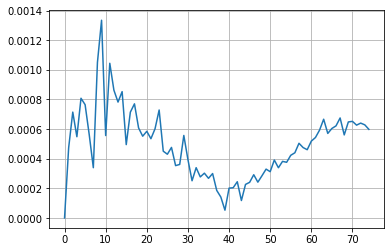

In [ ]:
check_signal(data_df, 0, 0)


In [ ]:
no_idx, left_idx, right_idx = np.where(dY == 1), np.where(dY == 0), np.where(dY == 2)

In [ ]:
right_idx

(array([ 6877,  6878,  6879, ..., 56306, 56307, 56308], dtype=int64),)

In [ ]:
6900 in right_idx[0]

True

In [ ]:
def plot_stuff(index=25):
    ax = inputs[index][:, :1]
    ay = inputs[index][:, 1:2]
    az = inputs[index][:, 2:3]
    gx = inputs[index][:, 3:4]
    gy = inputs[index][:, 4:5]
    gz = inputs[index][:, 5:]
    
    ax = ax.reshape((1,150))
    ay = ay.reshape((1,150))
    az = az.reshape((1,150))
    gx = gx.reshape((1,150))
    gy = gy.reshape((1,150))
    gz = gz.reshape((1,150))
    
    xr = range(SAMPLES_PER_GESTURE)
    plt.plot(xr, ax[0])
    plt.plot(xr, ay[0])
    plt.plot(xr, az[0])
    plt.legend(["aX", "aY", "aZ"])
    plt.grid()
    plt.ylabel("Acceleration values")
    plt.xlabel("Samples")
    plt.savefig("acc_test_visualize_noisy.png")
    plt.show()

In [ ]:
data_df.agg([min, max])

In [ ]:
nb_values

In [ ]:
test_nb_values = copy.deepcopy(nb_values)

In [ ]:
test_nb_values

In [ ]:
normalize_columns(test_nb_values, column_type="a")
normalize_columns(test_nb_values, column_type="m")
normalize_columns(test_nb_values, column_type="g")

In [ ]:
test_nb_values

In [ ]:
only_acc_gyro = test_nb_values[:, :-3]
only_acc_gyro.shape

In [ ]:
summed_signals = np.sum(only_acc_gyro, axis=1)

In [ ]:
summed_signals

In [ ]:
def plot_arr(arr, _range=None):
    if _range is not None:
        x = np.arange(0, _range[1] - _range[0])
        plt.plot(x, arr[_range[0]: _range[1]])
    else:
        x = np.arange(0, len(arr))
        plt.plot(x, arr)
    #plt.plot(x, arr[_range[0]: _range[1]])
    plt.grid()
    plt.show()

In [ ]:
plot_arr(summed_signals)

In [ ]:
yf = fft(summed_signals)
xf = fftfreq(len(summed_signals), 1 / SAMPLE_RATE)

In [ ]:
plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
np.argmax(yf)

In [ ]:
yf

In [ ]:
fft to discriminate between the two settings
windows on the signal (doing something, not doing anything) noise vs movement (find features to discriminate between these two situations)
amplitude could be enough as well, but there could be more

focus on analysis, training set etc
windows around the gesture when it happens, and windows on when nothing happens

windows of the time series, last 5 seconds for example (classifier for right, left, nothing)

window size is important!!!

features associated with larger time wondows or smaller windows

document infrastructure, the way data was taken, analysis method, features

In [ ]:
plot_signal_and_fft(test_nb_values[:, 2])

In [ ]:
test_nb_values.shape

In [ ]:
########### LOOKING INTO MIN, MAX, AVG, MEDIAN ETC for different windows

In [ ]:
save_model_lite(model)

In [ ]:
print(np.sum(one_hot_Y, axis=0))
print(dataX.shape)

In [ ]:
#### create a balanced smaller dataset

In [ ]:
get_balanced_dataset(dX, dY, one_hot_Y)

In [ ]:
no_idx, left_idx, right_idx = np.where(dY == 1), np.where(dY == 0), np.where(dY == 2)

In [ ]:
print(no_idx, left_idx, right_idx)
print(len(left_idx[0]))
print(len(right_idx[0]))
bal_size = min(len(left_idx[0]), len(right_idx[0]))

In [ ]:
bal_left, bal_nothing, bal_right = np.random.choice(left_idx[0], size=bal_size, replace=False), np.random.choice(no_idx[0], size=bal_size, replace=False), np.random.choice(right_idx[0], size=bal_size, replace=False)   

In [ ]:
bal_left

In [ ]:
leftX, left_Y = getX_Y_bal(bal_left, dataX, one_hot_Y)
rightX, right_Y = getX_Y_bal(bal_right, dataX, one_hot_Y)
noX, no_Y = getX_Y_bal(bal_nothing, dataX, one_hot_Y)

In [ ]:
allY_idxs = np.concatenate([bal_nothing, bal_left, bal_right])
print(allY_idxs)
print(bal_nothing)
print(bal_left)
print(bal_right)
allY_no_one_hot = dY[allY_idxs]

In [ ]:
evaluate_model(yo, bal_Y, allY_no_one_hot)

In [ ]:
tt = np.array([0.9536290168762207,
  0.955600380897522,
  0.9525731801986694,
  0.9515640735626221,
  0.9646821618080139])
tt.mean()

In [ ]:
bal_Y = np.concatenate([no_Y, left_Y, right_Y], axis=0)
bal_X = np.concatenate([noX, leftX, rightX], axis=0)

In [ ]:
testX = copy.deepcopy(bal_X)

In [ ]:
yo = testX[:, :30, :]

In [ ]:
yo.shape

In [ ]:
bal_model = define_model(lr=0.007)
train_model(bal_model, yo, bal_Y, epochs=75, batch_size=64)

In [ ]:
save_model_lite(bal_model, "balanced_trained_bs64_no_magneto_lr_007")

In [ ]:
bal_model.summary()

In [ ]:
bal_model = define_model(lr=0.005)
train_model(bal_model, bal_X, bal_Y, callbacks=[lrate], epochs=75, batch_size=32)

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.07
   drop = 0.2
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)